# Image Classification: Manhattan vs Euclidean Distance

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Settings
data_path = "animal_dataset"
classes = ['cat', 'dog', 'panda']
k_list = [1, 3, 5, 7, 9]
folds = 5

In [178]:
data = []
labels = []

print("Loading images...")

for i, label in enumerate(classes):
    folder = os.path.join(data_path, label)
    files = os.listdir(folder)
    
    for f in files:
        if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg'):
            path = os.path.join(folder, f)
            img = Image.open(path).convert('L')  # Grayscale
            img = img.resize((32, 32))
            
            # Flatten and normalize
            arr = np.array(img).flatten() / 255.0
            
            data.append(arr)
            labels.append(i)

X = np.array(data)
y = np.array(labels)

print(f"Loaded {len(X)} images.")

Loading images...
Loaded 300 images.


In [179]:
def get_l1_dist(x1, x2):
    return np.sum(np.abs(x1 - x2))

def get_l2_dist(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def predict(X_train, y_train, x_test, k, dist_func):
    dists = []
    for i in range(len(X_train)):
        d = dist_func(x_test, X_train[i])
        dists.append((d, y_train[i]))
    
    dists.sort(key=lambda x: x[0])
    neighbors = [label for _, label in dists[:k]]
    
    # Return most common label
    return max(set(neighbors), key=neighbors.count)

In [180]:
# Shuffle data
idx = np.arange(len(X))
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Split folds
X_folds = np.array_split(X, folds)
y_folds = np.array_split(y, folds)

l1_accs = {k: [] for k in k_list}
l2_accs = {k: [] for k in k_list}

print("Running 5-Fold Cross-Validation...")

for i in range(folds):
    # Validation set is current fold
    X_val = X_folds[i]
    y_val = y_folds[i]
    
    # Training set is the rest
    X_train = np.concatenate([X_folds[j] for j in range(folds) if j != i])
    y_train = np.concatenate([y_folds[j] for j in range(folds) if j != i])
    
    for k in k_list:
        correct_l1 = 0
        correct_l2 = 0
        
        for j in range(len(X_val)):
            p_l1 = predict(X_train, y_train, X_val[j], k, get_l1_dist)
            p_l2 = predict(X_train, y_train, X_val[j], k, get_l2_dist)
            
            if p_l1 == y_val[j]: correct_l1 += 1
            if p_l2 == y_val[j]: correct_l2 += 1
        
        l1_accs[k].append(correct_l1 / len(X_val))
        l2_accs[k].append(correct_l2 / len(X_val))
    
    print(f"Fold {i+1} done.")

Running 5-Fold Cross-Validation...
Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.



Average Accuracy:
K	L1	L2
1	0.367	0.360
3	0.407	0.390
5	0.407	0.387
7	0.413	0.417
9	0.420	0.393


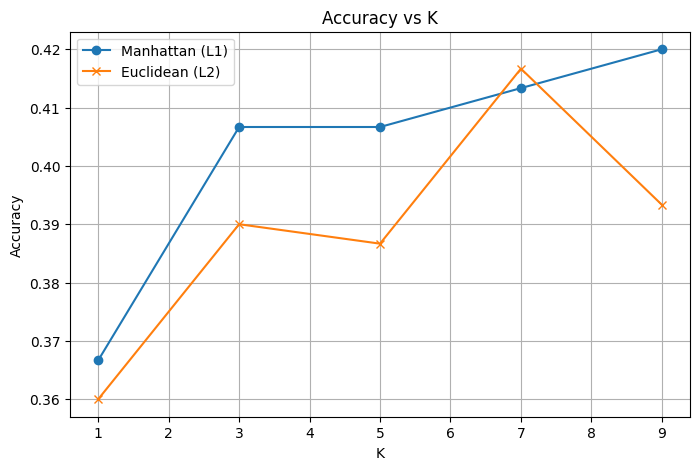

In [181]:
# Average accuracies
avg_l1 = [np.mean(l1_accs[k]) for k in k_list]
avg_l2 = [np.mean(l2_accs[k]) for k in k_list]

print("\nAverage Accuracy:")
print("K\tL1\tL2")
for i, k in enumerate(k_list):
    print(f"{k}\t{avg_l1[i]:.3f}\t{avg_l2[i]:.3f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_list, avg_l1, 'o-', label='Manhattan (L1)')
plt.plot(k_list, avg_l2, 'x-', label='Euclidean (L2)')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K')
plt.legend()
plt.grid(True)
plt.show()

In [183]:
print("\nTop 5 Predictions (Validation Set):")
print("-" * 40)

k_best = 9

for i in range(5):
    pred = predict(X_train, y_train, X_val[i], k_best, get_l1_dist)
    actual = y_val[i]
    
    res = "CORRECT" if pred == actual else "WRONG"
    print(f"Image {i+1}: True: {classes[actual]:<6} | Pred: {classes[pred]:<6} -> {res}")


Top 5 Predictions (Validation Set):
----------------------------------------
Image 1: True: cat    | Pred: dog    -> WRONG
Image 2: True: cat    | Pred: cat    -> CORRECT
Image 3: True: cat    | Pred: cat    -> CORRECT
Image 4: True: dog    | Pred: panda  -> WRONG
Image 5: True: panda  | Pred: cat    -> WRONG
